In [3]:
import os
import numpy as np
import torch
import pandas as pd
from biopandas.pdb import PandasPdb
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from Bio.PDB import DSSP, HSExposureCB, PPBuilder, is_aa, NeighborSearch
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.SeqUtils import seq1
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, ComplementNB, BernoulliNB
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from timeit import default_timer as timer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score


2024-09-19 11:07:29.518007: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-19 11:07:29.607215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 11:07:29.710190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 11:07:29.733952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 11:07:29.798550: I tensorflow/core/platform/cpu_feature_guar

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
current_directory = os.getcwd()
path_ring = current_directory + "/data/features_ring/"
path_pdb = current_directory + "/data/pdb_files/"

In [3]:
dfs = []
for filename in os.listdir(path_ring):
    dfs.append(pd.read_csv(path_ring + filename, sep='\t'))
df = pd.concat(dfs)

df.dropna(inplace=True)
y = df['Interaction'].astype('category')

# Add Feature: CA-CA Distances between source & target residues

In [41]:
from Bio import PDB
import numpy as np
import os
from tqdm import tqdm
from joblib import Parallel, delayed


parser = PDB.PDBParser(QUIET=True)


def get_residue_distance(pdb_id, s_resi, t_resi, s_ch, t_ch, pdb_file_path):
    """Calculates CA-CA distance between two residues in a PDB file"""

    structure = parser.get_structure(pdb_id, pdb_file_path)
    model = structure[0]


    try: # locate source- & target-chains
        s_chain = model[s_ch]
        t_chain = model[t_ch]
    except KeyError:
        raise ValueError(f"Chain {s_ch} or {t_ch} not found in structure {pdb_id}")


    try: # locate source- & target-residues
        s_residue = s_chain[s_resi]
        t_residue = t_chain[t_resi]
    except KeyError:
        raise ValueError(f"Residue {s_resi} or {t_resi} not found in chains {s_ch} or {t_ch}")


    try: # locate alpha carbons
        s_ca = s_residue['CA']
        t_ca = t_residue['CA']
    except KeyError:
        raise ValueError(f"Alpha-carbon not found in residue {s_resi} or {t_resi}")
    

    s_ca_coord = s_ca.get_coord()
    t_ca_coord = t_ca.get_coord()

    distance = np.linalg.norm(s_ca_coord - t_ca_coord)

    return distance


def process_row(index, row, pdb_directory):

    pdb_id = row['pdb_id']
    s_resi = row['s_resi']
    t_resi = row['t_resi']
    s_ch = row['s_ch']
    t_ch = row['t_ch']

    pdb_file_path = os.path.join(pdb_directory, f'{pdb_id}.pdb')

    if not os.path.isfile(pdb_file_path):
        print(f"File {pdb_file_path} does not exist.")
        return None

    try:
        distance = get_residue_distance(pdb_id, s_resi, t_resi, s_ch, t_ch, pdb_file_path)
        return distance
    except Exception as e:
        print(f"Error processing {pdb_id} (row {index}): {e}")
        return None


def calculate_distances_parallel(df, pdb_directory, n_jobs=-1):
    # Use Parallel to process each row in the dataframe in parallel
    ca_distances = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(index, row, pdb_directory) for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Rows")
    )
    
    # Add the result to the dataframe
    df['CA_CA_distance'] = ca_distances
    return df

if not os.path.exists(current_directory + '/data/df_data.pkl'):
    pdb_directory = path_pdb
    df = calculate_distances_parallel(df, pdb_directory, n_jobs=-1)
else:
    df = pd.read_pickle(current_directory + '/data/df_data.pkl')

# Add Feature: Sequence Neighbors (3 left/3 right) Aminoacid Type & Phi/Psi

In [ ]:
def compute_neighbors(pdb_id, s_ch, s_resi, t_ch, t_resi, path_pdb):

    pdb_file = path_pdb + f"{pdb_id}.pdb"

    # Initialize variables for source (s_) and target (t_) residues
    s_prev_resn, s_prev_phi, s_prev_psi = [None]*3, [None]*3, [None]*3
    s_next_resn, s_next_phi, s_next_psi = [None]*3, [None]*3, [None]*3

    t_prev_resn, t_prev_phi, t_prev_psi = [None]*3, [None]*3, [None]*3
    t_next_resn, t_next_phi, t_next_psi = [None]*3, [None]*3, [None]*3

    if not os.path.isfile(pdb_file):
        return {
            's_1_prev_resn': s_prev_resn[0], 's_1_prev_phi': s_prev_phi[0], 's_1_prev_psi': s_prev_psi[0],
            's_2_prev_resn': s_prev_resn[1], 's_2_prev_phi': s_prev_phi[1], 's_2_prev_psi': s_prev_psi[1],
            's_3_prev_resn': s_prev_resn[2], 's_3_prev_phi': s_prev_phi[2], 's_3_prev_psi': s_prev_psi[2],

            's_1_next_resn': s_next_resn[0], 's_1_next_phi': s_next_phi[0], 's_1_next_psi': s_next_psi[0],
            's_2_next_resn': s_next_resn[1], 's_2_next_phi': s_next_phi[1], 's_2_next_psi': s_next_psi[1],
            's_3_next_resn': s_next_resn[2], 's_3_next_phi': s_next_phi[2], 's_3_next_psi': s_next_psi[2]
        }, {
            't_1_prev_resn': t_prev_resn[0], 't_1_prev_phi': t_prev_phi[0], 't_1_prev_psi': t_prev_psi[0],
            't_2_prev_resn': t_prev_resn[1], 't_2_prev_phi': t_prev_phi[1], 't_2_prev_psi': t_prev_psi[1],
            't_3_prev_resn': t_prev_resn[2], 't_3_prev_phi': t_prev_phi[2], 't_3_prev_psi': t_prev_psi[2],

            't_1_next_resn': t_next_resn[0], 't_1_next_phi': t_next_phi[0], 't_1_next_psi': t_next_psi[0],
            't_2_next_resn': t_next_resn[1], 't_2_next_phi': t_next_phi[1], 't_2_next_psi': t_next_psi[1],
            't_3_next_resn': t_next_resn[2], 't_3_next_phi': t_next_phi[2], 't_3_next_psi': t_next_psi[2],
        }

    # Load structure using PDBParser
    structure = PDB.PDBParser(QUIET=True).get_structure(pdb_id, pdb_file)

    ppb = PDB.PPBuilder()

    for model in structure:
        for chain in model:
            if chain.id == s_ch or chain.id == t_ch:
                # Build the polypeptide for the current chain
                polypeptides = ppb.build_peptides(chain)

                # For each polypeptide in the chain
                for poly in polypeptides:
                    phi_psi = poly.get_phi_psi_list()  # Returns list of tuples (phi, psi)
                    for i, residue in enumerate(poly):
                        res_id = residue.id[1]

                        # For the source chain s_ch
                        if chain.id == s_ch:
                            if res_id == s_resi - 3:
                                s_prev_resn[2], s_prev_phi[2], s_prev_psi[2] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == s_resi - 2:
                                s_prev_resn[1], s_prev_phi[1], s_prev_psi[1] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == s_resi - 1:
                                s_prev_resn[0], s_prev_phi[0], s_prev_psi[0] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == s_resi + 1:
                                s_next_resn[0], s_next_phi[0], s_next_psi[0] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == s_resi + 2:
                                s_next_resn[1], s_next_phi[1], s_next_psi[1] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == s_resi + 3:
                                s_next_resn[2], s_next_phi[2], s_next_psi[2] = residue.resname, phi_psi[i][0], phi_psi[i][1]
 
                        # For the target chain t_ch
                        if chain.id == t_ch:
                            if res_id == t_resi - 3:
                                t_prev_resn[2], t_prev_phi[2], t_prev_psi[2] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == t_resi - 2:
                                t_prev_resn[1], t_prev_phi[1], t_prev_psi[1] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == t_resi - 1:
                                t_prev_resn[0], t_prev_phi[0], t_prev_psi[0] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == t_resi + 1:
                                t_next_resn[0], t_next_phi[0], t_next_psi[0] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == t_resi + 2:
                                t_next_resn[1], t_next_phi[1], t_next_psi[1] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == t_resi + 3:
                                t_next_resn[2], t_next_phi[2], t_next_psi[2] = residue.resname, phi_psi[i][0], phi_psi[i][1]

    # Return the data for 3 neighbors on both sides for both source and target residues
    return {
        's_1_prev_resn': s_prev_resn[0], 's_1_prev_phi': s_prev_phi[0], 's_1_prev_psi': s_prev_psi[0],
        's_2_prev_resn': s_prev_resn[1], 's_2_prev_phi': s_prev_phi[1], 's_2_prev_psi': s_prev_psi[1],
        's_3_prev_resn': s_prev_resn[2], 's_3_prev_phi': s_prev_phi[2], 's_3_prev_psi': s_prev_psi[2],

        's_1_next_resn': s_next_resn[0], 's_1_next_phi': s_next_phi[0], 's_1_next_psi': s_next_psi[0],
        's_2_next_resn': s_next_resn[1], 's_2_next_phi': s_next_phi[1], 's_2_next_psi': s_next_psi[1],
        's_3_next_resn': s_next_resn[2], 's_3_next_phi': s_next_phi[2], 's_3_next_psi': s_next_psi[2]
    }, {
        't_1_prev_resn': t_prev_resn[0], 't_1_prev_phi': t_prev_phi[0], 't_1_prev_psi': t_prev_psi[0],
        't_2_prev_resn': t_prev_resn[1], 't_2_prev_phi': t_prev_phi[1], 't_2_prev_psi': t_prev_psi[1],
        't_3_prev_resn': t_prev_resn[2], 't_3_prev_phi': t_prev_phi[2], 't_3_prev_psi': t_prev_psi[2],

        't_1_next_resn': t_next_resn[0], 't_1_next_phi': t_next_phi[0], 't_1_next_psi': t_next_psi[0],
        't_2_next_resn': t_next_resn[1], 't_2_next_phi': t_next_phi[1], 't_2_next_psi': t_next_psi[1],
        't_3_next_resn': t_next_resn[2], 't_3_next_phi': t_next_phi[2], 't_3_next_psi': t_next_psi[2],
    }



def process_row(row, path_pdb):
    pdb_id = row['pdb_id']
    s_ch = row['s_ch']
    t_ch = row['t_ch']
    s_resi = row['s_resi']
    t_resi = row['t_resi']

    return compute_neighbors(pdb_id, s_ch, s_resi, t_ch, t_resi, path_pdb)


def process_dataset(df, path_pdb):

    # Accumulate results
    results = Parallel(n_jobs=-1)(
        delayed(process_row)(row, path_pdb) for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Dataset")
    )

    # Check for None in results
    valid_results = [(s, t) if s is not None and t is not None else ({}, {}) for s, t in results]

    if len(valid_results) != len(results):
        print(f"Found {len(results) - len(valid_results)} invalid results (None or bad pairs).")

    # Extract results
    s_neighbors, t_neighbors = zip(*results)

    # Convert results into df
    s_df = pd.DataFrame(s_neighbors)
    t_df = pd.DataFrame(t_neighbors)

    neighbor_df = pd.concat([s_df, t_df], axis=1)

    # Reset indices to avoid mismatches
    df.reset_index(drop=True, inplace=True)
    neighbor_df.reset_index(drop=True, inplace=True)

    new_df = pd.concat([df, neighbor_df], axis=1)

    return new_df


if not os.path.exists(current_directory + '/data/df_data.pkl'):
    df = process_dataset(df, path_pdb)

    columns_to_convert = [
        's_1_prev_resn', 's_2_prev_resn', 's_3_prev_resn', 
        's_1_next_resn', 's_2_next_resn', 's_3_next_resn', 
        't_1_prev_resn', 't_2_prev_resn', 't_3_prev_resn', 
        't_1_next_resn', 't_2_next_resn', 't_3_next_resn'
    ]

    # Dictionary for three-letter to one-letter amino acid code
    three_to_one_letter = {
        'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
        'GLU': 'E', 'GLN': 'Q', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
        'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
        'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
    }

    # Apply conversion to each of the specified columns
    for col in columns_to_convert:
        df[col] = df[col].map(three_to_one_letter)

    # Drop NA's
    df = df.dropna(inplace=True)

else:
    df = pd.read_pickle(current_directory + '/data/df_data.pkl')


# Add Feature: Neighbors in 3D Space with sequence_separtion=6 

In [ ]:
import os
import numpy as np
import pandas as pd
from Bio import PDB
from tqdm import tqdm
from Bio.PDB import PDBParser, NeighborSearch
from joblib import Parallel, delayed

three_to_one_letter = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLU': 'E', 'GLN': 'Q', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}

parser = PDB.PDBParser(QUIET=True)

def compute_residue_names(pdb_id, s_ch, s_resi, t_ch, t_resi):

    pdb_file = os.path.join(path_pdb, f'{pdb_id}.pdb')
    structure = parser.get_structure(pdb_id, pdb_file)
    
    source_residue = structure[0][s_ch][s_resi]
    target_residue = structure[0][t_ch][t_resi]

    all_atoms = list(structure.get_atoms())  # Search across the entire structure
    ns = NeighborSearch(all_atoms)

    # Residues within 8.0 Å distance
    contacts = ns.search_all(8.0, level="R")

    # Exclude contacts with sequence separation <= 6
    filtered_contacts = []
    for res1, res2 in contacts:

        is_amino_acid_1 = is_aa(res1)
        is_amino_acid_2 = is_aa(res2)

        if is_amino_acid_1 and is_amino_acid_2:
            res1_id = res1.get_id()[1]
            res2_id = res2.get_id()[1]

            if abs(res1_id - res2_id) > 6:
                filtered_contacts.append((res1, res2))

    # Extract coordinates
    source_coords = np.array([atom.coord for atom in source_residue.get_atoms()])
    target_coords = np.array([atom.coord for atom in target_residue.get_atoms()])

    min_distance_s, min_distance_t = float('inf'), float('inf')
    s_resn_neighbour, t_resn_neighbour = None, None

    # Process filtered contacts to find the closest residues
    for residue1, residue2 in filtered_contacts:
        if residue1 == target_residue or residue2 == target_residue:
            other_residue = residue2 if residue1 == target_residue else residue1
            other_coords = np.array([atom.coord for atom in other_residue.get_atoms()])
            distances = np.linalg.norm(target_coords[:, np.newaxis] - other_coords, axis=-1)
            min_distance = np.min(distances)

            if min_distance < min_distance_t:
                min_distance_t = min_distance
                t_resn_neighbour = other_residue

        if residue1 == source_residue or residue2 == source_residue:
            other_residue = residue2 if residue1 == source_residue else residue1
            other_coords = np.array([atom.coord for atom in other_residue.get_atoms()])
            distances = np.linalg.norm(source_coords[:, np.newaxis] - other_coords, axis=-1)
            min_distance = np.min(distances)

            if min_distance < min_distance_s:
                min_distance_s = min_distance
                s_resn_neighbour = other_residue

    return (s_resn_neighbour.get_resname(),
            t_resn_neighbour.get_resname())


def process_row(row):
    pdb_id = row['pdb_id']
    s_ch = row['s_ch']
    t_ch = row['t_ch']
    s_resi = row['s_resi']
    t_resi = row['t_resi']

    s_resn_neighbour, t_resn_neighbour = compute_residue_names(pdb_id, s_ch, s_resi, t_ch, t_resi)
    
    s_resn_neighbour = three_to_one_letter.get(s_resn_neighbour, s_resn_neighbour)
    t_resn_neighbour = three_to_one_letter.get(t_resn_neighbour, t_resn_neighbour)
    
    return s_resn_neighbour, t_resn_neighbour


def process_dataset(df, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(row) for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing rows")
    )

    s_resn_neighbours_list, t_resn_neighbours_list = zip(*results)
    df['s_resn_neighbour'] = s_resn_neighbours_list
    df['t_resn_neighbour'] = t_resn_neighbours_list

    return df


if not os.path.exists(current_directory + '/data/df_data.pkl'):
    df = process_dataset(df, path_pdb)
else:
    df = pd.read_pickle(current_directory + '/data/df_data.pkl')

# Data Transformation

In [1]:
label_encoder = LabelEncoder()

def encode_object_columns(df):
    label_encoder = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].astype(str)
            df[column] = label_encoder.fit_transform(df[column])
    return df

df.dropna(inplace=True)
df = encode_object_columns(df)
df

NameError: name 'LabelEncoder' is not defined

In [ ]:
X = df.drop(columns=['Interaction'])
y = df['Interaction']

y = to_categorical(y, num_classes=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Feature Importance

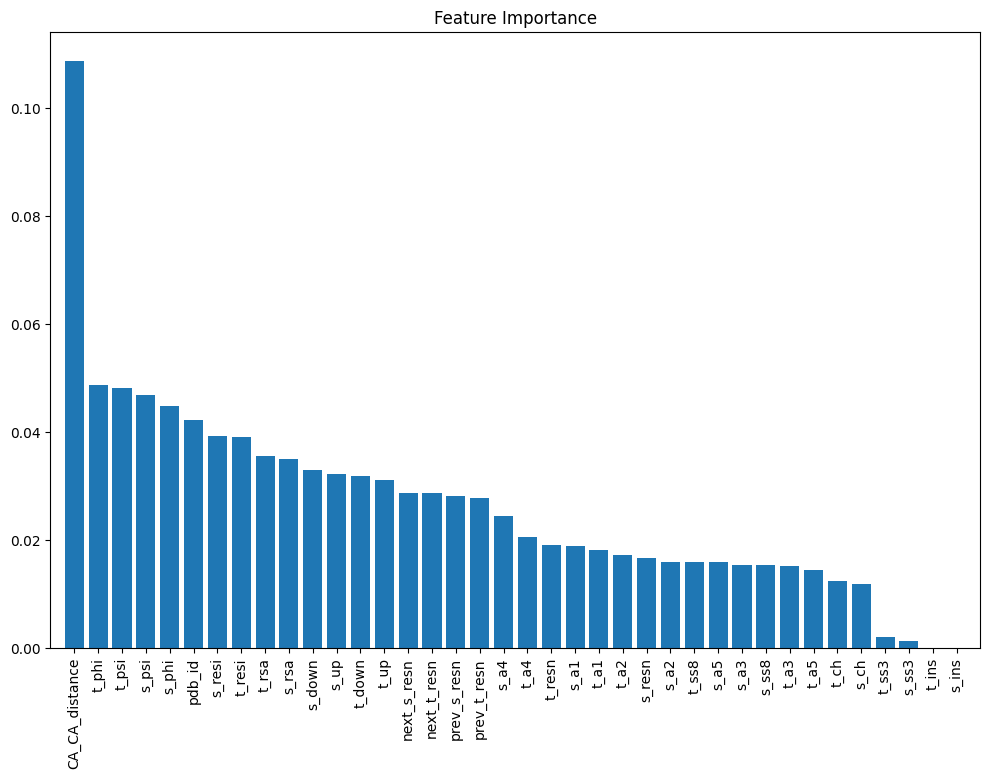

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Sample a subset of the data
sample_size = 50000
df_sample = df.sample(n=sample_size, random_state=42)

X_sample = df_sample.drop(columns=['Interaction'])
y_sample = df_sample['Interaction']

# Convert labels to one-hot encoding if necessary and then back to labels for Random Forest
y_sample = pd.get_dummies(y_sample)  # One-hot encode if needed
y_sample_labels = y_sample.values.argmax(axis=1)  # Convert back to labels

rf = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)  # Reduced parameters
rf.fit(X_sample, y_sample_labels)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importance")
plt.bar(range(X_sample.shape[1]), importances[indices], align="center")
plt.xticks(range(X_sample.shape[1]), X_sample.columns[indices], rotation=90)
plt.xlim([-1, X_sample.shape[1]])
plt.show()


In [ ]:
X = df.drop(columns=['Interaction', 't_ss3', "s_ss3", "t_ins", "s_ins" ])
y = df['Interaction']

y = to_categorical(y, num_classes=10) # One-hot encode the labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Handle Imbalanced Data

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Model Training

In [ ]:
from imblearn.over_sampling import ADASYN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score



model = Sequential()

# Input layer and first hidden layer
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Second hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Third hidden layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# Fourth hidden layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(7, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define K-Fold cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store scores for each fold
fold_accuracies = []
per_class_accuracies = []

# ADASYN for balancing the data
adasyn = ADASYN()

# K-Fold Cross Validation
for train_index, val_index in tqdm(kf.split(X_train), total=kf.get_n_splits(), desc="Cross-Validation"):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
    X_train_fold_resampled, y_train_fold_resampled = adasyn.fit_resample(X_train_fold, y_train_fold)

    # Create a new model instance for each fold
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train_fold_resampled, y_train_fold_resampled,
                        validation_data=(X_val_fold, y_val_fold),
                        epochs=50,
                        batch_size=32,
                        class_weight=class_weight_dict,
                        callbacks=[early_stopping],
                        verbose=0)  # Set verbose to 1 for detailed output

   # Predict the labels for the validation fold
    y_val_pred = np.argmax(model.predict(X_val_fold), axis=1)
    y_val_true = np.argmax(y_val_fold, axis=1)

    # Compute balanced accuracy for the current fold
    balanced_acc = balanced_accuracy_score(y_val_true, y_val_pred)
    print(f"Balanced accuracy for current fold: {balanced_acc:.4f}")

    fold_accuracies.append(balanced_acc)

    # Calculate and print per-class accuracy
    class_report = classification_report(y_val_true, y_val_pred, output_dict=True)
    per_class_acc = {f"Class {cls}": class_report[str(cls)]['precision'] for cls in range(7)}
    print(f"Per-class accuracy for current fold: {per_class_acc}")

    per_class_accuracies.append(per_class_acc)

# Calculate and print the average balanced accuracy across all folds
average_balanced_accuracy = np.mean(fold_accuracies)
print(f"Average balanced accuracy across all folds: {average_balanced_accuracy:.4f}")

# Calculate average per-class accuracy across all folds
average_per_class_acc = {f"Class {cls}": np.mean([acc[f"Class {cls}"] for acc in per_class_accuracies]) for cls in range(7)}
print(f"Average per-class accuracy across all folds: {average_per_class_acc}")


In [ ]:
import csv

# Save the fold accuracies and per-class accuracies to a CSV file
with open('kfold_results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write headers
    writer.writerow(['Fold', 'Balanced Accuracy'] + [f'Class {i} Accuracy' for i in range(7)])
    
    # Write data for each fold
    for i, (fold_acc, class_acc) in enumerate(zip(fold_accuracies, per_class_accuracies)):
        writer.writerow([i + 1, fold_acc] + [class_acc.get(f'Class {cls}', 0) for cls in range(7)])
    
    # Write average accuracies
    writer.writerow(['Average', average_balanced_accuracy] + [average_per_class_acc.get(f'Class {cls}', 0) for cls in range(7)])

# Predict

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = np.argmax(y_test, axis=1)

mcc = matthews_corrcoef(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
avg_precision = average_precision_score(y_test, y_pred_proba, average='macro')

print(f"Test accuracy: {test_acc:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Average Precision Score: {avg_precision:.4f}")
